In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm
import matplotlib.colors as colors

import seaborn as sns
# sns.set_theme(style="whitegrid")

%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Working at GT ####

LOCATION: 	 GT
USER: 	 cchen641
ICDATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data
ANA_DIR: 	 /storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output



In [2]:
class args:
    out_dir = "/storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output"
# import argparse
# p = argparse.ArgumentParser(description="Unbindling script",
#                             formatter_class=argparse.RawTextHelpFormatter)
# p.add_argument("--out_dir", default="/storage/home/hhive1/cchen641/data/icecube/data/greco_grb/data/csky_output", type=str, help="output root directory")
# args = p.parse_args()

In [5]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")

# load per GRB best: tw, TS, ns, pre_p

In [29]:
tws, tss, nss, pre_ps = [], [], [], []
tw_in_seconds = [10, 25, 50, 100, 250, 500]
for idx in df.grb_name.index:
    grb_name = df.grb_name[idx]
    ts_ns_p = np.load(ANA_DIR+f"/unblind/ts_ns_p/{grb_name}_ts_ns_p.npy")
    ts_grb = ts_ns_p['ts']
    ns_grb = ts_ns_p['ns']
    pre_p_grb = ts_ns_p['pval']
    min_i = np.argmin(pre_p_grb)
    tws.append(tw_in_seconds[min_i])
    tss.append(ts_grb[min_i])
    nss.append(ns_grb[min_i])
    pre_ps.append(pre_p_grb[min_i])
    

In [30]:
df_result = df.copy()
df_result['tw'] = np.array(tws)
df_result['ts'] = np.array(tss)
df_result['ns'] = np.array(nss)
df_result['pre_p'] = np.array(pre_ps)

# for each GRB, trial correct due to stacked time windows

In [34]:
def get_post_p_for_grb(grb_name, pre_p):
    """
    effective trial correction due to multiple time windows
    
    Parameters
    ----------
        grb_name: str
            name of the grb
        pre_p: float or array_like
            one or multiple pre_trial p value(s)
        
    Returns
    -------
        post_p: float or array_like
            one or multiple post_trial p value(s)
    """
    pre_p = np.float32(pre_p)
    pre_post = np.load(ANA_DIR + f"/effective_trial/pre_post/{grb_name}_effective_trial.npy")
    idx = np.searchsorted(pre_post['pre_trial_p'], pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, pre_post['post_trial_p'].shape[0] - 1)
    return pre_post['post_trial_p'][idx]

In [35]:
###### ~ 2 cpu min
df_result['post_p'] = df_result.apply(
    lambda row : get_post_p_for_grb(row['grb_name'],row['pre_p']), 
    axis = 1
)

In [48]:
def binomial_test(p_values, epsilon=None):
    """
    Perform IceCube binomial test
    
    Parameters
    ----------
        p_values: array_like
            an array of p-values
        
    Returns
    -------
        best_k: int
            number of p-values that minimizes the binomial probability
            Note this is 1-index'ed
        
        best_binomial_p: float
            the optimized binomial probability
            
        threshold_p_value: float
            the best_k-th p_value (a.k.a. p_k)
            this GRB and all GRBs having p_values smaller than this threshold_p_value are important
            
        indices: array_like
            GRB indices after sorting (assume the input p_values' indices are from 0 - 2267)
            
        
        binomial_ps: array_like
            binomial probabilities for different k=1,2,...,N
    """
    p_values = np.array(p_values)
    N = p_values.size
    ks = np.argsort(p_values)
    p_values = np.sort(p_values)
    binomial_ps = stats.binom.sf(np.r_[0:N], N, p_values)
    best_k = np.argmin(binomial_ps) + 1
    best_binomial_p = binomial_ps[best_k - 1]
    if (epsilon is not None) and (1.0 - best_binomial_p < epsilon):
        return N, 1, p_values[-1], ks, binomial_ps
    threshold_p_value = p_values[best_k - 1]
    return best_k, best_binomial_p, threshold_p_value, ks, binomial_ps

In [43]:
binomial_result = binomial_test(df_result['post_p'])

In [80]:
def plot_binom_example_from_p_values(p_values, mark_indices=[], save_fig=False):
    """
    p_values here are assumed corrected already
    
    Parameters
    ----------
        p_values: array_like
            shape: 2268
            
        mark_indices: array_like
            0-indexed: 0,1,2,...,2267
            if provided, draw those p-values differently
            
        save_fig: bool
            do we plot/save (True/False) the plot
        
    Returns
    -------
        ax: matplotlib axes
            
        binomial_result: dict
    
    """
    ## example null hypothesis Binomial Test
    binomial_result = binomial_test(p_values)

    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    # 2268 GRBs
    x = np.r_[1:2268+1]
    # p_values
    sorted_p_values = np.sort(p_values)
    ax.scatter(x, sorted_p_values, label="Pre-trial p-values", s=2)
    if len(mark_indices) > 0:
        mark_indices = np.array(mark_indices)
        sorted_indices = np.argsort(p_values)
        mark_ks = np.ravel([np.argwhere(sorted_indices==x) for x in mark_indices]) + 1
        ax.scatter(mark_ks, sorted_p_values[mark_ks-1], color=sns.color_palette()[2], s=20, marker="x", label="Marked p-value(s)")
    # Binomial Probability
    ax.scatter(x, binomial_result[4], label="Binomial p-values", s=2)
    # best Binomial
    ax.vlines(binomial_result[0], 0, binomial_result[1], 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2)
    ax.axhline(binomial_result[1], 0, 2268, 
               linestyle='-.', color=sns.color_palette()[1], linewidth=2,
               label=f"k = {binomial_result[0]}\nP_binom = {binomial_result[1]}")
    # uniform line
    ax.plot(x, x/2268., "--")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Number of GRBs")
    ax.set_ylabel("p-value")
    # ax.set_title(f"{ag.grb_name}")
    ax.grid(True)
    ax.legend()
    if save_fig:
        fig.savefig(ANA_DIR+f"/unblind/binomial_plot.png")
    return ax, binomial_result

(<AxesSubplot:xlabel='Number of GRBs', ylabel='p-value'>,
 (7,
  0.16640384327768598,
  0.0019759999122470617,
  array([1392,  747, 1075, ...,  885,  883, 2267]),
  array([0.80073537, 0.62693523, 0.36938135, ..., 1.        , 1.        ,
         1.        ])))

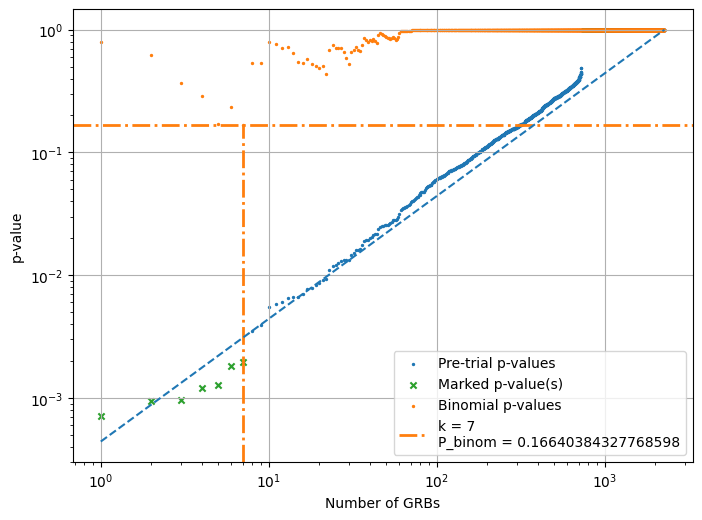

In [81]:
plot_binom_example_from_p_values(
    np.array(df_result['post_p']), 
    mark_indices=binomial_result[3][:binomial_result[0]],
    save_fig=True
)


In [59]:
def get_binomial_post_p(binomial_pre_p):
    files = glob(ANA_DIR+f"/binomial_test/null_binom/binomial_results/null_binomial_results_numRun1000000_seed*.npy")
    files = sorted(files, key=lambda x: int(x[x.find("_seed")+5:x.find(".npy")]))
    best_binomial_p_100000000 = np.concatenate([np.load(file) for file in files])[:,1]
    ######## pre-post mapping #######
    hist, bin_edges = np.histogram(best_binomial_p_100000000, 
                               bins=np.r_[
                                   np.logspace(np.log10(best_binomial_p_100000000.min()),np.log10(1.0), 100000), 
                                   1.2
                               ], 
                               density=True)
    pre_trial_p = bin_edges
    post_trial_p = np.r_[np.cumsum(hist*np.diff(bin_edges)), 1]
    dt = np.dtype([('pre_trial_p', np.float32), ('post_trial_p', np.float32)])
    pre_post = np.transpose(np.array([pre_trial_p, post_trial_p]))
    pre_post = np.array(list(map(tuple, pre_post)), dtype=dt)
    #################################
    idx = np.searchsorted(pre_post['pre_trial_p'], binomial_pre_p, side='right') - 1
    idx = np.maximum(idx, 0)
    idx = np.minimum(idx, len(pre_post['post_trial_p']) - 1)
    return pre_post['post_trial_p'][idx]

In [60]:
print(f"The final binomial post-trial p value is: {get_binomial_post_p(binomial_result[1])}")

0.7909987